### Initialization

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import lgbloch.viz as viz
from bloch4spin.basis import bloch_init
from bloch4spin.evolution import GeneralizedBlochEvolutionMatrix, GeneralizedBlochState
from bloch4spin.observable import GeneralizedBlochObservable

# Initialize global engine state `current_engine` similar to lgbloch.engine._get_engine_env
from lgbloch.engine import (
    distributions_from_deltas,
    distributions_from_times,
    projectors_Jz,
    spin_ops,
)
from lgbloch.lgi import (
    entropic_LGI,
    entropic_LGI_for_order_k,
    entropic_LGI_from_chain_rule,
    standard_LGI_dichotomic,
    wigner_LGI_dichotomic,
)

# Enable LaTeX formatting
plt.rcParams['text.usetex'] = True

### Parallelism and Performance Note
- Grid evaluation (`plot_boolean_region`) in `viz` supports parallelism: you can explicitly pass `n_jobs` (e.g., `n_jobs=8`) to speed up calculation. However, please note that the global state of `bloch4spin` (such as `bloch_init(d)`) may have race conditions under multi-threading, so be cautious when simulating mixed dimensions.
- Curve plotting (`plot_multioutput_curves`) is executed serially to ensure stability in complex environments.
- Probability distribution calculations strictly adopt "intrusive" semantics: each subset is calculated independently, and marginal distributions are never used for summation.

### ELGIs in spin-2 system (Fig. 2)

In [6]:
# Setup d=5 system
_d = 5
bloch_init(_d)
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)
L_H_mat_5 = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)
rho0_5 = np.eye(_d, dtype=complex) / _d
r0_5 = GeneralizedBlochState.from_matrix(rho0_5)
obs_list_5 = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# 1. Three-point calculation (n=3)
def evaluate_elgi_n3(dt):
    times = [0, dt, 2*dt]
    jps = distributions_from_times(times, d=5, L_mat=L_H_mat_5, r0=r0_5, obs_list=obs_list_5)
    
    devi = entropic_LGI_from_chain_rule(3, jps)
    min2 = entropic_LGI_for_order_k(2, 3, jps)
    min3 = entropic_LGI_for_order_k(3, 3, jps)
    
    return [devi, min2, min3]

# 2. Four-point calculation (n=4)
def evaluate_elgi_n4(dt):
    times = [0, dt, 2*dt, 3*dt]
    jps = distributions_from_times(times, d=5, L_mat=L_H_mat_5, r0=r0_5, obs_list=obs_list_5)
    
    devi = entropic_LGI_from_chain_rule(4, jps)
    min2 = entropic_LGI_for_order_k(2, 4, jps)
    min3 = entropic_LGI_for_order_k(3, 4, jps)
    min4 = entropic_LGI_for_order_k(4, 4, jps)
    
    return [devi, min2, min3, min4]

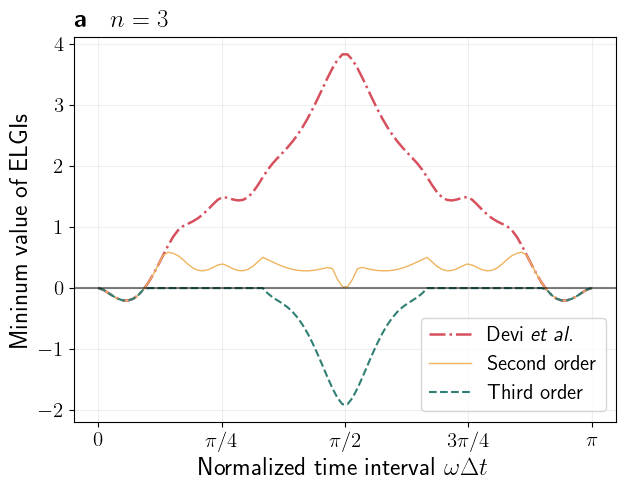

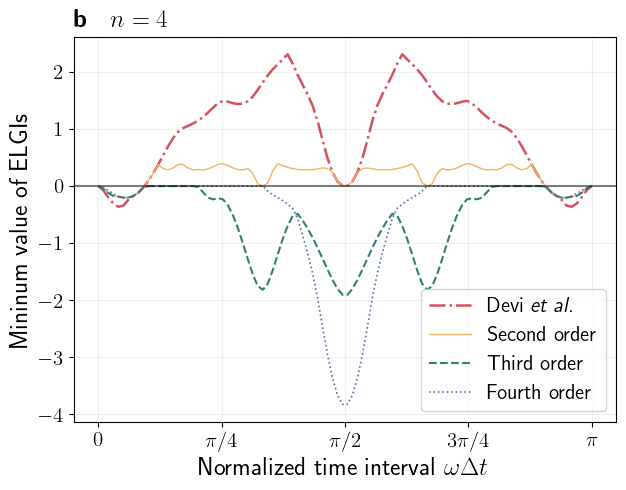

In [7]:
delta_ts = np.linspace(0, np.pi, 100)

fig, ax = viz.plot_multioutput_curves(
    evaluate_elgi_n3,
    delta_ts,
    label=[r'Devi {\itshape et al.}', r'Second order', r'Third order'],
    color=[(215/255, 80/255, 94/255), (239/255, 180/255, 96/255), (47/255, 127/255, 116/255)],
    linewidth=[1.8, 1.0, 1.5],
    linestyle=['-.', '-', '--']
)
ax.set_xlabel(r'Normalized time interval $\omega\Delta t$')
ax.set_ylabel(r'Mininum value of ELGIs')
ax.xticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
ax.set_xticks(ax.xticks)
ax.set_xticklabels([r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"])
ax.yticks = [-2, -1, 0, 1, 2, 3, 4]
ax.set_yticks(ax.yticks)
ax.set_yticklabels(["$-2$", "$-1$", "$0$", "$1$", "$2$", "$3$", "$4$"])
ax.legend(loc='lower right', fontsize=15)
ax.axhline(0, color='k', linestyle='-', alpha=0.5)
ax.text(0.0, 1.07, r'{\bfseries a}\quad$n=3$', transform=ax.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/3-point-ELGIs.png', dpi=300, bbox_inches='tight')

fig, ax = viz.plot_multioutput_curves(
    evaluate_elgi_n4,
    delta_ts,
    label=[r'Devi {\itshape et al.}', r'Second order', r'Third order', r'Fourth order'],
    color=[(215/255, 80/255, 94/255), (239/255, 180/255, 96/255), (47/255, 127/255, 116/255), (88/255, 113/255, 166/255)],
    linewidth=[1.8, 1.0, 1.5, 1.2],
    linestyle=['-.', '-', '--', ':']
)
ax.set_xlabel(r'Normalized time interval $\omega\Delta t$')
ax.set_ylabel(r'Mininum value of ELGIs')
ax.xticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
ax.set_xticks(ax.xticks)
ax.set_xticklabels([r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"])
ax.yticks = [-4, -3, -2, -1, 0, 1, 2]
ax.set_yticks(ax.yticks)
ax.set_yticklabels(["$-4$", "$-3$", "$-2$", "$-1$", "$0$", "$1$", "$2$"])
ax.legend(loc='lower right', fontsize=15)
ax.axhline(0, color='k', linestyle='-', alpha=0.5)
ax.text(0.0, 1.07, r'{\bfseries b}\quad$n=4$', transform=ax.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/4-point-ELGIs.png', dpi=300, bbox_inches='tight')

### SLGIs, WLGIs and ELGIs in spin-1/2 system (Fig. 3)

In [8]:
# Choose Hilbert-space dimension
_d = 2
bloch_init(_d)
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)
L_H_mat = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)
L_K_mat = GeneralizedBlochEvolutionMatrix.from_Lindblad(Jm)
rho0 = np.eye(_d, dtype=complex) / _d
r0 = GeneralizedBlochState.from_matrix(rho0)
obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# Global engine dict used by helper functions above
current_engine = {
    "d": _d,
    "L_mat": L_H_mat,
    "r0": r0,
    "obs_list": obs_list,
}
ATOL = 1e-10

# All helper functions now fetch engine state (L, r0, obs_list) from `current_engine`.

def _engine_kwargs():
    e = current_engine
    return dict(d=e["d"], L_mat=e["L_mat"], r0=e["r0"], obs_list=e["obs_list"])

def bool_LG_three_point(t12, t23):
    deltas = (t12, t23)
    jps = distributions_from_deltas(deltas, **_engine_kwargs())
    e_min = entropic_LGI(3, jps)
    s_min = standard_LGI_dichotomic(3, jps)
    w_min = wigner_LGI_dichotomic(3, jps)
    return [e_min < -ATOL, s_min < -ATOL, w_min < -ATOL]

In [ ]:
current_engine = {
    "d": _d,
    "L_mat": L_H_mat + 0.03 * L_K_mat,
    "r0": r0 + 0.0 * Jz,
    "obs_list": obs_list,
}
t12_range = (0.0, 4 * np.pi)
t23_range = (0.0, 4 * np.pi)

fig, ax = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=1000,
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255), (88/255, 113/255, 166/255)],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='overlay',
    save_data="data/3-point-LGIs-a-1000.npz"
)
ax.set_xlabel(r'Normalized time interval $\omega\Delta t_{12}$')
ax.set_ylabel(r'Normalized time interval $\omega\Delta t_{23}$')
ax.text(0.0, 1.06, r'{\bfseries a}\quad$\gamma=0.03\omega$', transform=ax.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/plot-3-point-LGIs-a.png', dpi=300, bbox_inches='tight')

Parallel execution: 21 chunks (target 20) on 5 workers.
Progress: 1/21 chunks

Parallel execution: 21 chunks (target 20) on 5 workers.
Progress: 21/21 chunks
Boolean region data saved to: d:\Archive\Code\lgbloch\data\3-point-LGIs-b-1000.npz


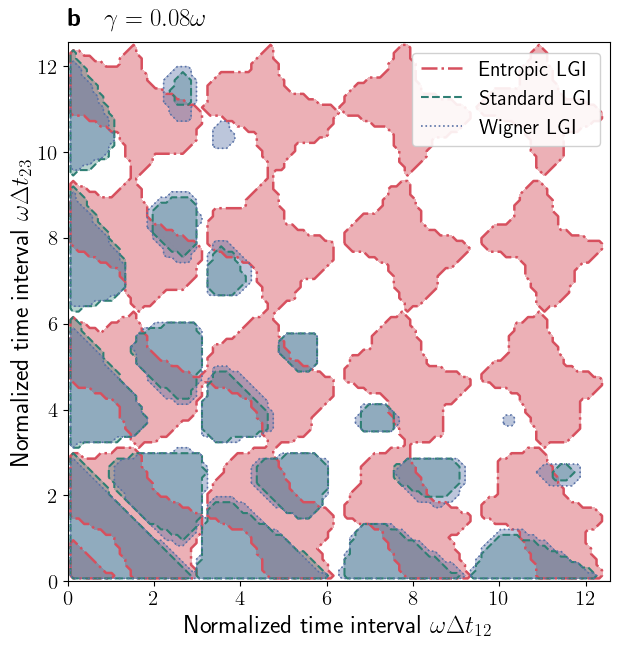

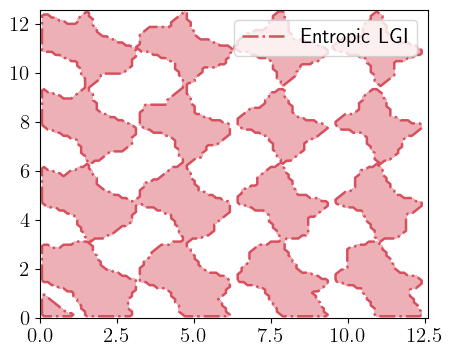

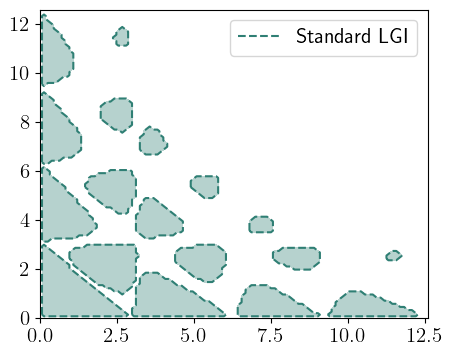

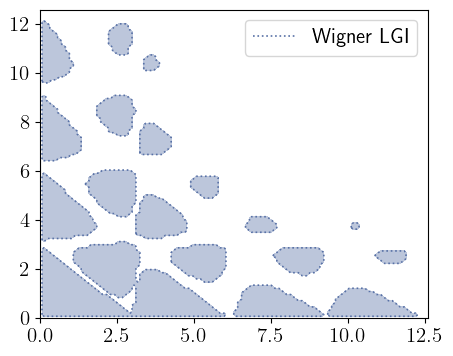

In [ ]:
current_engine = {
    "d": _d,
    "L_mat": L_H_mat + 0.08 * L_K_mat,
    "r0": r0 + 0.0 * Jz,
    "obs_list": obs_list,
}
t12_range = (0.0, 4 * np.pi)
t23_range = (0.0, 4 * np.pi)

# 'both' mode to generate separate figures for each LGI
fig, ax, separate_figs = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=1000,
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255), (88/255, 113/255, 166/255)],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='both',
    save_data="data/3-point-LGIs-b-1000.npz"
)
ax.set_xlabel(r'Normalized time interval $\omega\Delta t_{12}$')
ax.set_ylabel(r'Normalized time interval $\omega\Delta t_{23}$')
ax.text(0.0, 1.06, r'{\bfseries b}\quad$\gamma=0.08\omega$', transform=ax.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/plot-3-point-LGIs-b.png', dpi=300, bbox_inches='tight')

In [ ]:
# Replot from saved data using the new function in viz.py
# This demonstrates how to reproduce the figure with consistent styling
# without re-running the simulation.

fig, ax = viz.replot_boolean_region(
    "data/3-point-LGIs-a-1000.npz",
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255), (88/255, 113/255, 166/255)],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='overlay'
)

ax.set_xlabel(r'Normalized time interval $\omega\Delta t_{12}$')
ax.set_ylabel(r'Normalized time interval $\omega\Delta t_{23}$')
ax.xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2, 3*np.pi, 7*np.pi/2, 4*np.pi]
ax.set_xticks(ax.xticks)
ax.set_xticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$", r"$5\pi/2$", r"$3\pi$", r"$7\pi/2$", r"$4\pi$"])
ax.yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2, 3*np.pi, 7*np.pi/2, 4*np.pi]
ax.set_yticks(ax.xticks)
ax.set_yticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$", r"$5\pi/2$", r"$3\pi$", r"$7\pi/2$", r"$4\pi$"])
ax.text(0.0, 1.06, r'{\bfseries a}\quad$\gamma=0.03\omega$', transform=ax.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/replot-3-point-LGIs-a.png', dpi=300, bbox_inches='tight')

fig, ax = viz.replot_boolean_region(
    "data/3-point-LGIs-b-1000.npz",
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255), (88/255, 113/255, 166/255)],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='overlay'
)

ax.set_xlabel(r'Normalized time interval $\omega\Delta t_{12}$')
ax.set_ylabel(r'Normalized time interval $\omega\Delta t_{23}$')
ax.xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2, 3*np.pi, 7*np.pi/2, 4*np.pi]
ax.set_xticks(ax.xticks)
ax.set_xticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$", r"$5\pi/2$", r"$3\pi$", r"$7\pi/2$", r"$4\pi$"])
ax.yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2, 3*np.pi, 7*np.pi/2, 4*np.pi]
ax.set_yticks(ax.xticks)
ax.set_yticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$", r"$5\pi/2$", r"$3\pi$", r"$7\pi/2$", r"$4\pi$"])
ax.text(0.0, 1.06, r'{\bfseries b}\quad$\gamma=0.08\omega$', transform=ax.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/replot-3-point-LGIs-b.png', dpi=300, bbox_inches='tight')

### Dissipative qubit system (Fig. 4)

In [ ]:
# Four-level system: |0>, |1>, |e>, |g|
def get_four_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma):
    bloch_init(4)
    H = np.zeros((4,4), dtype=complex)
    H[0,0] = E0
    H[1,1] = E1
    H[2,2] = Ee
    H[3,3] = Eg
    H[0,1] = omega0
    H[1,0] = np.conj(omega0)
    H[1,2] = omega
    H[2,1] = np.conj(omega)
    L_mat_H = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(H)
    L = np.zeros((4,4), dtype=complex)
    L[3,2] = np.sqrt(gamma)
    L_mat_L = GeneralizedBlochEvolutionMatrix.from_Lindblad(L)
    L_mat = L_mat_H + L_mat_L
    
    rho0 = np.zeros((4,4), dtype=complex)
    rho0[0,0] = 0.5
    rho0[1,1] = 0.5
    r0 = GeneralizedBlochState.from_matrix(rho0)
    obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(4, indices=(0,1))]
    return L_mat, r0, obs_list

# Effective three-level system: |0>, |1>, |g|
def get_effective_three_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma):
    bloch_init(3)
    H = np.zeros((3,3), dtype=complex)
    H[0,0] = E0
    H[1,1] = E1
    H[2,2] = Eg
    H[0,1] = omega0
    H[1,0] = np.conj(omega0)
    Delta = Ee - E1
    Gamma_eff = np.abs(omega)**2 * gamma / (Delta**2 + (gamma/2)**2)
    L = np.zeros((3,3), dtype=complex)
    L[2,1] = np.sqrt(Gamma_eff)
    L_mat_H = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(H)
    L_mat_L = GeneralizedBlochEvolutionMatrix.from_Lindblad(L)
    L_mat = L_mat_H + L_mat_L

    rho0 = np.zeros((3,3), dtype=complex)
    rho0[0,0] = 0.5
    rho0[1,1] = 0.5
    r0 = GeneralizedBlochState.from_matrix(rho0)
    obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(3, indices=(0,1))]
    return L_mat, r0, obs_list

def simulate_dissipative_qubit(times, E0, E1, Ee, Eg, omega0, omega, gamma):
    # Four-level
    bloch_init(4)
    L_mat_4, r0_4, obs_list_4 = get_four_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma)
    jps_4 = distributions_from_times(times, d=4, L_mat=L_mat_4, r0=r0_4, obs_list=obs_list_4)
    # Effective three-level
    bloch_init(3)
    L_mat_3, r0_3, obs_list_3 = get_effective_three_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma)
    jps_3 = distributions_from_times(times, d=3, L_mat=L_mat_3, r0=r0_3, obs_list=obs_list_3)
    return jps_4, jps_3

# --- Simulation & Plotting ---
def calc_specific_elgi(jps):
    # D_{1,3} = H(Q1,Q2) + H(Q2,Q3) - H(Q1,Q2,Q3) - H(Q2)
    # This is Conditional Mutual Information I(Q1; Q3 | Q2)
    dist = jps.distributions
    from lgbloch.lgi import shannon_entropy
    h12 = shannon_entropy(dist[(1, 2)])
    h23 = shannon_entropy(dist[(2, 3)])
    h123 = shannon_entropy(dist[(1, 2, 3)])
    h2 = shannon_entropy(dist[(2,)])
    return h12 + h23 - h123 - h2

In [ ]:
# Parameters
E0 = 0.0
E1 = 2.58
Ee = 4.79
Eg = -0.003
omega0 = 1.0
omega = 1.0
gamma_list = [0.1, 0.3, 0.5, 0.7]

t_start = np.pi / (4 * omega0)

def evaluate_lgi(dt, gamma_list=gamma_list):
    # Times: t1, t2, t3
    times = [t_start, t_start + dt, t_start + 2*dt]
    results = []
    for gamma in gamma_list:
        L_mat_4, r0_4, obs_list_4 = get_four_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma)
        bloch_init(4)
        jps_4 = distributions_from_times(times, d=4, L_mat=L_mat_4, r0=r0_4, obs_list=obs_list_4)
        val_4 = calc_specific_elgi(jps_4)
        results.append(val_4)
    return results

delta_ts = np.linspace(0, 5*np.pi/2, 120)

fig, ax = viz.plot_multioutput_curves(
    lambda dt: evaluate_lgi(dt, gamma_list=gamma_list),
    delta_ts,
    label=[r'$\gamma=0.1\omega$', r'$\gamma=0.3\omega$', r'$\gamma=0.5\omega$', r'$\gamma=0.7\omega$'],
    color=[(215/255, 80/255, 94/255), (239/255, 180/255, 96/255), (47/255, 127/255, 116/255), (88/255, 113/255, 166/255)],
    linewidth=[1.8, 1.8, 1.8, 1.8],
    linestyle=['-.', '-', '--', ':']
)
ax.set_xlabel(r'Normalized Time Interval $\omega\Delta t$')
ax.set_ylabel(r'Magnitude of ELGI $\mathcal{D}_{1,3}$')
ax.xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2]
ax.set_xticks(ax.xticks)
ax.set_xticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$", r"$5\pi/2$"])
ax.legend(loc='lower left', fontsize=15)
ax.axhline(0, color='k', linestyle='-', alpha=0.5)
ax.text(-0.20, 1.00, r'{\bfseries b}', transform=ax.transAxes,
                fontsize=24, verticalalignment='top', horizontalalignment='left')
fig.savefig('pic/non-Markovian.png', dpi=300, bbox_inches='tight')
